In [5]:

import keras
import wandb
from wandb.keras import WandbCallback
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
import groceries
import matplotlib.pyplot as plt


Using TensorFlow backend.
wandb: WARNING Keras version 2.3.1 is not fully supported. Required keras >= 2.4.0


In [6]:
(x_train, y_train_raw), (x_test, y_test_raw), class_names = groceries.load_data()

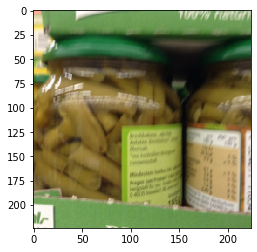

In [7]:
# take a look at the kinds of images we're dealing with
plt.imshow(x_train[100].astype(int))

In [8]:
# Print out the classes we need to target
class_names

['BEANS',
 'CAKE',
 'CANDY',
 'CEREAL',
 'CHIPS',
 'CHOCOLATE',
 'COFFEE',
 'CORN',
 'FISH',
 'FLOUR',
 'HONEY',
 'JAM',
 'JUICE',
 'MILK',
 'NUTS',
 'OIL',
 'PASTA',
 'RICE',
 'SODA',
 'SPICES',
 'SUGAR',
 'TEA',
 'TOMATO_SAUCE',
 'VINEGAR',
 'WATER']

(array([639., 439., 672., 199., 406., 602., 295., 504., 381., 560.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

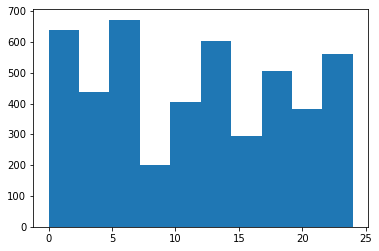

In [9]:
# check how balanced our class distribution is
plt.hist(y_train_raw)

In [10]:
# One hot encode ouput
y_train = keras.utils.to_categorical(y_train_raw)
y_test = keras.utils.to_categorical(y_test_raw)

In [11]:
wandb.init(project="transfer-learn")

wandb: Currently logged in as: scueroinc (use `wandb login --relogin` to force relogin)


In [12]:
# We build an extremely simple perceptron to try to fit our data

x_train_normalized = x_train / 255.
x_test_normalized = x_test / 255.

very_simple_model=Sequential()
very_simple_model.add(Flatten())
very_simple_model.add(Dense(25, activation="sigmoid"))
very_simple_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


very_simple_model.fit(x_train_normalized, y_train, epochs=10, validation_data=(x_test_normalized, y_test), callbacks=[WandbCallback()])

Train on 4697 samples, validate on 250 samples
Epoch 1/10
4697/4697 [==============================] - 3s 619us/step - loss: 8.7144 - accuracy: 0.0270 - val_loss: 9.0705 - val_accuracy: 0.0400
Epoch 2/10
4697/4697 [==============================] - 2s 488us/step - loss: 8.4544 - accuracy: 0.0268 - val_loss: 8.5698 - val_accuracy: 0.0400
Epoch 3/10
4697/4697 [==============================] - 2s 503us/step - loss: 8.3096 - accuracy: 0.0268 - val_loss: 8.5698 - val_accuracy: 0.0400
Epoch 4/10
4697/4697 [==============================] - 2s 490us/step - loss: 8.3096 - accuracy: 0.0268 - val_loss: 8.5698 - val_accuracy: 0.0400
Epoch 5/10
4697/4697 [==============================] - 2s 486us/step - loss: 8.3096 - accuracy: 0.0268 - val_loss: 8.5698 - val_accuracy: 0.0400
Epoch 6/10
4697/4697 [==============================] - 2s 489us/step - loss: 8.3096 - accuracy: 0.0268 - val_loss: 8.5698 - val_accuracy: 0.0400
Epoch 7/10
4697/4697 [==============================] - 2s 486us/step - loss:

In [13]:
# Load ResNet50 Trained on imagenet
resnet_model = ResNet50(weights="imagenet")

102858752/102853048 [==============================] - 10s 0us/step


In [14]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [15]:
from keras.preprocessing import image
import numpy as np
img = image.load_img('elephant.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = resnet_model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


40960/35363 [==================================] - 0s 3us/step
Predicted: [('n01871265', 'tusker', 0.48542824), ('n02504013', 'Indian_elephant', 0.34329173), ('n02504458', 'African_elephant', 0.17125076)]


In [16]:
# We should preprocess the images the same way resnet images were preprocessed
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)

In [17]:
# Build a new model that is ResNet50 minus the very last layer
last_layer = resnet_model.get_layer("avg_pool")

resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)
resnet_layers.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [18]:
# We use our resnet to "predict" but because we have removed the top layer, 
# this outputs the activations of the second to last layer on our dataset

x_train_features = resnet_layers.predict(x_train_preprocessed)

In [20]:
x_test_features = resnet_layers.predict(x_test_preprocessed)

In [21]:
feature_model=Sequential()
feature_model.add(Dense(25, activation="sigmoid"))
feature_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
wandb.init(project="transfer-learn")
feature_model.fit(x_train_features, y_train, epochs=50, validation_data=(x_test_features, y_test), callbacks=[WandbCallback()])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,9
val_loss,9.07046
val_accuracy,0.04
loss,9.04
accuracy,0.02683
_step,9
_runtime,43
_timestamp,1603513761
best_val_loss,8.56983
best_epoch,1


epoch,▁▂▃▃▄▅▆▆▇█
val_loss,█▁▁▁▁▁▁▁██
val_accuracy,▁▁▁▁▁▁▁▁▁▁
loss,▅▂▁▁▁▁▁▁▁█
accuracy,█▁▁▁▁▁▁▁▁▁
_step,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█


Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 0s 75us/step - loss: 1.6607 - accuracy: 0.5105 - val_loss: 1.3270 - val_accuracy: 0.6120
Epoch 2/50
4697/4697 [==============================] - 0s 60us/step - loss: 0.6955 - accuracy: 0.8054 - val_loss: 1.0845 - val_accuracy: 0.6520
Epoch 3/50
4697/4697 [==============================] - 0s 60us/step - loss: 0.4684 - accuracy: 0.8808 - val_loss: 0.9620 - val_accuracy: 0.7200
Epoch 4/50
4697/4697 [==============================] - 0s 60us/step - loss: 0.3437 - accuracy: 0.9182 - val_loss: 0.8964 - val_accuracy: 0.7200
Epoch 5/50
4697/4697 [==============================] - 0s 60us/step - loss: 0.2648 - accuracy: 0.9476 - val_loss: 0.8420 - val_accuracy: 0.7280
Epoch 6/50
4697/4697 [==============================] - 0s 60us/step - loss: 0.2023 - accuracy: 0.9681 - val_loss: 0.8527 - val_accuracy: 0.7400
Epoch 7/50
4697/4697 [==============================] - 0s 59us/step - loss: 0.1608

In [23]:
# We can directly stich the models together

new_model=Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(25, activation="sigmoid"))

new_model.layers[0].trainable=False

new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 25)                51225     
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
wandb.init(project="transfer-learn")
new_model.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_test_preprocessed, y_test), callbacks=[WandbCallback()])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,49
val_loss,0.84609
val_accuracy,0.784
loss,0.00189
accuracy,1.0
_step,49
_runtime,17
_timestamp,1603513944
best_val_loss,0.72302
best_epoch,15


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▅▄▃▃▂▂▁▂▁▁▁▁▁▁▂▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_accuracy,▁▃▅▅▆▆▇█▆▇▇▆█▇█▇█▇███▇████▇████▇▇███████
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇████████████████████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█


Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 46s 10ms/step - loss: 1.7989 - accuracy: 0.4758 - val_loss: 2.4712 - val_accuracy: 0.3040
Epoch 2/50
4697/4697 [==============================] - 44s 9ms/step - loss: 0.7985 - accuracy: 0.7737 - val_loss: 2.1391 - val_accuracy: 0.4200
Epoch 3/50
4697/4697 [==============================] - 44s 9ms/step - loss: 0.5585 - accuracy: 0.8497 - val_loss: 2.0524 - val_accuracy: 0.4560
Epoch 4/50
4697/4697 [==============================] - 44s 9ms/step - loss: 0.4158 - accuracy: 0.8929 - val_loss: 1.9541 - val_accuracy: 0.4840
Epoch 5/50
4697/4697 [==============================] - 44s 9ms/step - loss: 0.3359 - accuracy: 0.9189 - val_loss: 2.2381 - val_accuracy: 0.4240
Epoch 6/50
4697/4697 [==============================] - 44s 9ms/step - loss: 0.2625 - accuracy: 0.9455 - val_loss: 2.1895 - val_accuracy: 0.4320
Epoch 7/50
4697/4697 [==============================] - 44s 9ms/step - loss: 0.220

In [25]:
# We can allow some of the resnet layers to change as we train.  
# Typically you would want to lower the learning rate in conjunction with this.

new_model.layers[0].trainable = True

# We let the last 3 blocks train
for layer in new_model.layers[0].layers[:-11]:
    layer.trainable = False
for layer in new_model.layers[0].layers[-11:]:
    layer.trainable = True
    
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

wandb.init(project="transfer-learn")
new_model.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_test_preprocessed, y_test), callbacks=[WandbCallback()])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,49
val_loss,2.76753
val_accuracy,0.492
loss,0.0087
accuracy,0.99957
_step,49
_runtime,2196
_timestamp,1603516152
best_val_loss,1.95414
best_epoch,3


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,▅▂▂▁▃▂▃▂▂▂▄▂▅▅▄▄▄▄▆▄▄▃▅▆█▅▆▅▅▆▇▆▆▇▅▆▇█▅▇
val_accuracy,▁▄▅▆▅▆▅▅▆▅▅▆▅▅▆▇▆▆▆█▇▇▇▇▆▇▇▇▆▆▆▆▇▇██▇▆▇▆
loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇▇██████████████████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


Train on 4697 samples, validate on 250 samples
Epoch 1/50
4697/4697 [==============================] - 52s 11ms/step - loss: 0.2355 - accuracy: 0.9372 - val_loss: 2.1084 - val_accuracy: 0.5040
Epoch 2/50
4697/4697 [==============================] - 48s 10ms/step - loss: 0.0458 - accuracy: 0.9947 - val_loss: 0.9275 - val_accuracy: 0.7480
Epoch 3/50
4697/4697 [==============================] - 48s 10ms/step - loss: 0.0236 - accuracy: 0.9972 - val_loss: 0.8925 - val_accuracy: 0.7520
Epoch 4/50
4697/4697 [==============================] - 48s 10ms/step - loss: 0.0191 - accuracy: 0.9972 - val_loss: 0.8930 - val_accuracy: 0.7440
Epoch 5/50
4697/4697 [==============================] - 48s 10ms/step - loss: 0.0126 - accuracy: 0.9985 - val_loss: 0.8923 - val_accuracy: 0.7680
Epoch 6/50
4697/4697 [==============================] - 48s 10ms/step - loss: 0.0090 - accuracy: 0.9991 - val_loss: 1.0720 - val_accuracy: 0.7400
Epoch 7/50
4697/4697 [==============================] - 48s 10ms/step - loss: